In [1]:
import numpy as np
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

In [64]:
img = cv2.imread('dojacat.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

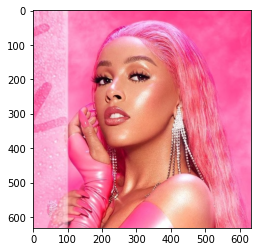

In [65]:
plt.imshow(img_rgb)

In [66]:
average = img_rgb.mean(axis=0).mean(axis=0)
print(average)

[236.7361776  126.79893046 153.51022723]


In [67]:
average_img = np.ones([100,100,3]) * average / 255.

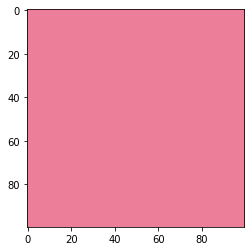

In [68]:
plt.imshow(average_img)